In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Create directories
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DEAP_CHANNEL_LOCATION_DICT

freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

dataset = DEAPDataset(root_path=f'E:\FYP\DEAP_dataset\zip_files\data_preprocessed_python',
                      io_path=f'E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747100363968_wpFQ9',
                      offline_transform=transforms.Compose([
                             transforms.BandDifferentialEntropy(band_dict=freq_bands),  # Apply DE feature extraction
                      ]),
                      online_transform=transforms.Compose([
                          transforms.To2d(),
                          transforms.ToTensor()
                      ]),
                      label_transform=transforms.Compose([
                          transforms.Select(['valence', 'arousal']),
                          transforms.Binary(5.0),
                          transforms.BinariesToCategory()
                      ]),
                      num_worker=4)
print(dataset[0])

<>:13: SyntaxWarning: invalid escape sequence '\F'
<>:14: SyntaxWarning: invalid escape sequence '\F'
<>:13: SyntaxWarning: invalid escape sequence '\F'
<>:14: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamza\AppData\Local\Temp\ipykernel_20060\754377537.py:13: SyntaxWarning: invalid escape sequence '\F'
  dataset = DEAPDataset(root_path=f'E:\FYP\DEAP_dataset\zip_files\data_preprocessed_python',
C:\Users\hamza\AppData\Local\Temp\ipykernel_20060\754377537.py:14: SyntaxWarning: invalid escape sequence '\F'
  io_path=f'E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747100363968_wpFQ9',
[2025-05-14 05:53:21] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\.torcheeg\datasets_1747100363968_wpFQ9.


(tensor([[[1.1133, 3.0094, 3.4046, 3.0341, 1.6964],
         [1.0742, 3.2409, 3.3717, 3.1913, 1.5171],
         [1.1781, 3.4088, 3.1853, 3.2634, 1.9229],
         [1.6778, 2.6700, 3.3696, 3.1086, 1.7142],
         [0.6457, 2.2498, 2.9879, 2.5813, 1.1083],
         [1.1392, 2.2641, 2.7772, 2.7511, 1.0465],
         [0.0125, 2.1866, 3.2820, 2.8930, 1.3125],
         [1.2121, 3.1930, 3.3882, 3.4827, 2.5031],
         [0.5054, 2.7580, 3.6947, 2.9956, 1.5674],
         [0.6462, 2.7226, 3.4068, 2.5674, 1.2629],
         [1.0938, 3.4452, 3.9285, 3.1678, 1.8972],
         [1.5552, 3.2019, 3.9790, 3.4432, 2.4233],
         [1.4797, 3.4187, 4.0361, 3.1311, 1.9660],
         [1.6763, 3.3519, 3.8791, 3.1933, 2.2270],
         [1.0572, 3.1224, 3.7096, 2.9091, 1.7720],
         [1.3668, 3.0972, 3.4053, 2.5028, 1.1896],
         [1.3244, 3.7032, 3.5050, 3.4798, 1.8252],
         [1.5007, 3.3375, 3.5419, 3.3965, 1.5551],
         [1.3846, 3.5990, 3.4498, 3.0084, 1.2822],
         [1.4698, 3.9276, 3.34

In [4]:
print(f"✅ Dataset loaded with {len(dataset)} samples")

✅ Dataset loaded with 76800 samples


In [7]:
X = []
y = []

for sample in dataset:
    feature_vector,label = sample

    X.append(feature_vector.flatten().numpy())
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Features shape: {X.shape}, Labels shape: {y.shape}")

✅ Features shape: (76800, 160), Labels shape: (76800,)


In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Convert dataset to features and labels
X = []
y = []

for sample in dataset:
    eeg_tensor, label = sample[0], sample[1]  # Category label from 0 to 3
    X.append(eeg_tensor.flatten().numpy())  # shape (160,)
    y.append(label)  # convert tensor scalar to int

X = np.array(X)
y = np.array(y)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Step 3: Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=[
    "Low Val & Low Arou (Class 0)",
    "Low Val & High Arou (Class 1)",
    "High Val & Low Arou (Class 2)",
    "High Val & High Arou (Class 3)"
]))

print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report:
                                precision    recall  f1-score   support

  Low Val & Low Arou (Class 0)       0.38      0.24      0.29      3120
 Low Val & High Arou (Class 1)       0.40      0.32      0.36      3552
 High Val & Low Arou (Class 2)       0.42      0.31      0.36      3192
High Val & High Arou (Class 3)       0.44      0.66      0.53      5496

                      accuracy                           0.42     15360
                     macro avg       0.41      0.38      0.38     15360
                  weighted avg       0.42      0.42      0.41     15360

🧮 Confusion Matrix:
[[ 740  455  437 1488]
 [ 331 1153  390 1678]
 [ 350  467  983 1392]
 [ 542  793  513 3648]]


e:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

X = []
y = []

for sample in dataset:
    eeg_tensor, label = sample  # (or unpack as a tuple)
    X.append(eeg_tensor.flatten().numpy())
    y.append(label)  # convert tensor scalar to int

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.24      0.29      3120
           1       0.40      0.32      0.36      3552
           2       0.42      0.31      0.36      3192
           3       0.44      0.66      0.53      5496

    accuracy                           0.42     15360
   macro avg       0.41      0.38      0.38     15360
weighted avg       0.42      0.42      0.41     15360

Confusion Matrix:
[[ 740  455  437 1488]
 [ 331 1153  390 1678]
 [ 350  467  983 1392]
 [ 542  793  513 3648]]


e:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


         Pred -1  Pred 0  Pred 1
True -1     8514    1383     327
True 0      1100    8763     253
True 1       612     597    9465


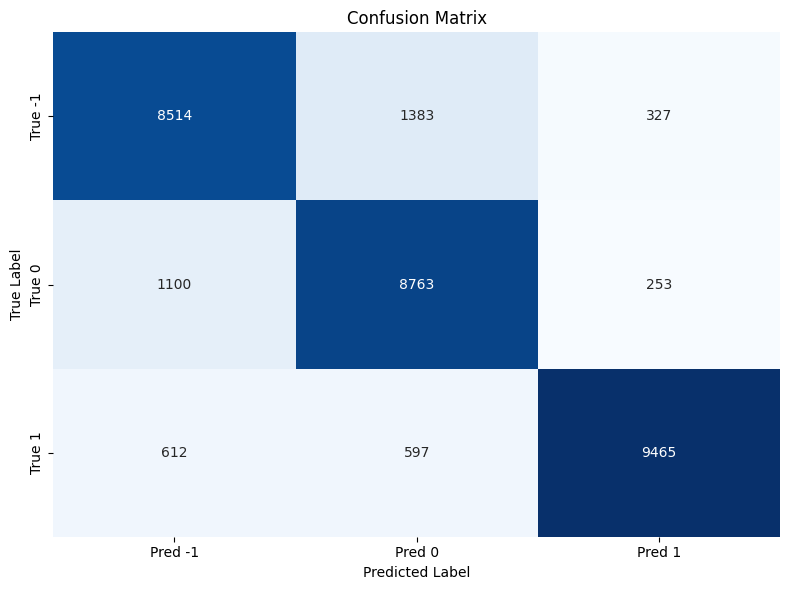

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Raw confusion matrix
conf_matrix = np.array([
    [8514, 1383, 327],
    [1100, 8763, 253],
    [612, 597, 9465]
])

# Define labels
labels = [-1, 0, 1]

# Create a labeled DataFrame
df_cm = pd.DataFrame(conf_matrix, index=[f'True {i}' for i in labels], columns=[f'Pred {i}' for i in labels])

# Print the DataFrame
print(df_cm)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
